In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
import time
# from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score 
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, cohen_kappa_score, log_loss
import warnings
warnings.filterwarnings('ignore')


In [2]:
df1 = pd.read_csv("Covid Dataset.csv")
df1

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Yes
1,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,...,Yes,No,No,No,Yes,Yes,No,No,No,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,...,Yes,Yes,Yes,No,No,No,No,No,No,Yes
3,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,...,No,No,Yes,No,Yes,Yes,No,No,No,Yes
4,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,...,No,Yes,No,Yes,No,Yes,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No,...,Yes,Yes,No,No,No,No,No,No,No,Yes
5430,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,...,Yes,No,No,No,No,No,No,No,No,Yes
5431,Yes,Yes,Yes,No,No,No,No,No,Yes,No,...,No,No,No,No,No,No,No,No,No,No
5432,Yes,Yes,Yes,No,Yes,No,No,Yes,Yes,No,...,No,No,No,No,No,No,No,No,No,No


In [3]:
df1.replace({'Yes': 1, 'No': 0}, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Breathing Problem                        5434 non-null   int64
 1   Fever                                    5434 non-null   int64
 2   Dry Cough                                5434 non-null   int64
 3   Sore throat                              5434 non-null   int64
 4   Running Nose                             5434 non-null   int64
 5   Asthma                                   5434 non-null   int64
 6   Chronic Lung Disease                     5434 non-null   int64
 7   Headache                                 5434 non-null   int64
 8   Heart Disease                            5434 non-null   int64
 9   Diabetes                                 5434 non-null   int64
 10  Hyper Tension                            5434 non-null   int64
 11  Fati

In [4]:
# Split the data into features (x) and target (y)
y = df1['COVID-19']
x = df1.drop(columns='COVID-19', axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [5]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [6]:
y_train_resampled.value_counts()

0    3495
1    3495
Name: COVID-19, dtype: int64

In [7]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best ROC AUC Score','Roc-auc Score', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'Time Elapsed (s)'])

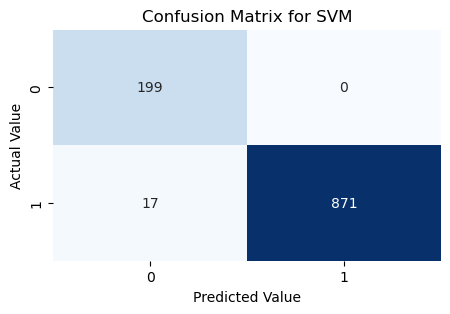

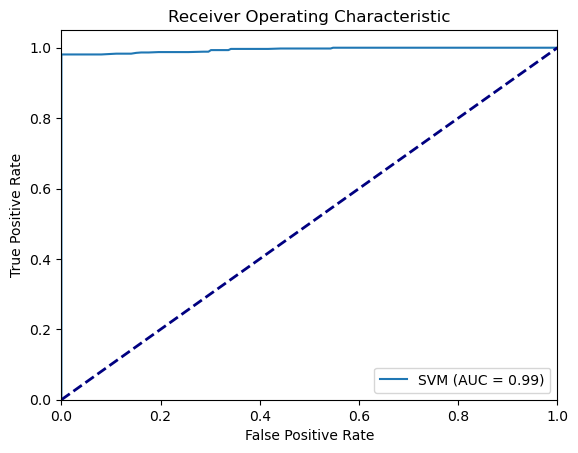

,Model,Best Parameters,Best ROC AUC Score,Roc-auc Score,Accuracy,Sensitivity,Specificity,Precision,F1 Score,Time Elapsed (s)
0,SVM,"{'C': 1, 'degree': 2, 'gamma': 'scale', 'kerne...",0.987391,0.994565,0.984361,0.980856,1.0,1.0,0.990335,130.561957


In [8]:
# Initialize a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame(columns=['Model', 'Feature', 'Importance'])

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

model = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(model, param_grid_svm, scoring='f1', cv=3)

start_time = time.time()
grid_search.fit(x_train_resampled, y_train_resampled)

# Get the best model from the grid search
best_svm_model = grid_search.best_estimator_

# Train the best model on the full training data
best_svm_model.fit(x_train_resampled, y_train_resampled)
end_time = time.time()

# Predict the class probabilities for ROC AUC curve
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]  # Use class 1 probabilities for ROC AUC

best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

y_pred = grid_search.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Calculate specificity
tn = np.sum((y_test == 0) & (y_pred == 0))
n = np.sum(y_test == 0)
specificity = tn / n

precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
time_elapsed = end_time - start_time

results_df = results_df.append({
    'Model': "SVM",
    'Best Parameters': best_params,
    'Best ROC AUC Score': best_roc_auc,
    'Roc-auc Score': roc_auc,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Precision': precision,
    'F1 Score': f1,
    'Time Elapsed (s)': time_elapsed
}, ignore_index=True)

# Plot ROC AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

results_df

In [9]:
results_df.to_excel("res.xlsx")